In [269]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from scipy.stats import randint as sp_randint
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [270]:
# load data
df_X = pd.read_csv('../data/X.csv', index_col=0)
df_y = pd.read_csv('../data/y.csv', index_col=0)

X = df_X.to_numpy()
y = df_y.values.ravel()  # 0 is HER2+, 1 is HR+, 2 is Triple Negative

category_labels = ['HER2+', 'HR+', 'Triple Neg']

In [273]:
def plot_confusion_matrix_all(y_test, y_pred, categories):
    """
    Plots a confusion matrix using seaborn to compare the ground truth labels
    and the model's predictions.

    Parameters:
    - y_test (array-like): True labels.
    - y_pred (array-like): Predictions from the model.
    - categories (list): List of category names for labeling the axes.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap from the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Summary Confusion Matrix')
    plt.show()

def roc_plot_all(X, y_true, y_pred, categories):
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=range(len(categories)))
    y_pred_bin = label_binarize(y_pred, classes=range(len(categories)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(8, 6))
    for i in range(len(categories)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {categories[i]} (AUC = {roc_auc[i]:.2f})')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Summary ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()


In [274]:
def nested_cv_rfc_all(x_data, y_targets, category_labels):
    rfc = RandomForestClassifier(random_state=42)
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_leaf_nodes": [50, 100, 200],
        "max_depth": [50, 100, 200],
        "min_samples_split": [2, 50, 100],
        "max_features": ['sqrt', 'log2']
    }
    
    # Configure the nested cross-validation procedure
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=2)

    outer_scores = []
    best_models = []
    all_test_indices = []
    all_test_preds = []
    all_test_true = []

    for train_index, test_index in outer_cv.split(x_data):
        X_train, X_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_targets[train_index], y_targets[test_index]
        
        grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_models.append(best_model)
        
        test_score = best_model.score(X_test, y_test)
        outer_scores.append(test_score)

        y_pred = best_model.predict(X_test)
        all_test_indices.append(test_index)
        all_test_preds.append(y_pred)
        all_test_true.append(y_test)

    # Aggregate all test predictions and true values
    all_test_indices = np.concatenate(all_test_indices)
    all_test_preds = np.concatenate(all_test_preds)
    all_test_true = np.concatenate(all_test_true)

    # Calculate the mean and standard deviation of the outer scores
    mean_accuracy = np.mean(outer_scores)
    std_accuracy = np.std(outer_scores)

    # Plot confusion matrix and ROC curve for the summary results
    plot_confusion_matrix_all(all_test_true, all_test_preds, category_labels)
    roc_plot_all(x_data, all_test_true, all_test_preds, category_labels)

    return {
        "mean_accuracy": mean_accuracy,
        "std_accuracy": std_accuracy,
        "best_models": best_models
    }


In [275]:
def nested_cv_logreg_all(x_data, y_targets, category_labels):
    # define the model
    log_reg = LogisticRegression(solver='liblinear', multi_class='ovr')

    # define the grid of hyperparameters
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'penalty': ['l1', 'l2'],
                  'max_iter': [100, 200, 300, 400, 500]}
    
    # Configure the nested cross-validation procedure
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=2)

    outer_scores = []
    best_models = []
    all_test_indices = []
    all_test_preds = []
    all_test_true = []

    for train_index, test_index in outer_cv.split(x_data):
        X_train, X_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_targets[train_index], y_targets[test_index]
        
        grid_search = GridSearchCV(log_reg, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_models.append(best_model)
        
        test_score = best_model.score(X_test, y_test)
        outer_scores.append(test_score)

        y_pred = best_model.predict(X_test)
        all_test_indices.append(test_index)
        all_test_preds.append(y_pred)
        all_test_true.append(y_test)

    # Aggregate all test predictions and true values
    all_test_indices = np.concatenate(all_test_indices)
    all_test_preds = np.concatenate(all_test_preds)
    all_test_true = np.concatenate(all_test_true)

    # Calculate the mean and standard deviation of the outer scores
    mean_accuracy = np.mean(outer_scores)
    std_accuracy = np.std(outer_scores)

    # Plot confusion matrix and ROC curve for the summary results
    plot_confusion_matrix_all(all_test_true, all_test_preds, category_labels)
    roc_plot_all(x_data, all_test_true, all_test_preds, category_labels)

    return {
        "mean_accuracy": mean_accuracy,
        "std_accuracy": std_accuracy,
        "best_models": best_models
    }

In [276]:
def nested_cv_knn_all(x_data, y_targets, category_labels):
    # define the model
    knn = KNeighborsClassifier()

    # define the grid of hyperparameters
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11],
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    # Configure the nested cross-validation procedure
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=2)

    outer_scores = []
    best_models = []
    all_test_indices = []
    all_test_preds = []
    all_test_true = []

    for train_index, test_index in outer_cv.split(x_data):
        X_train, X_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_targets[train_index], y_targets[test_index]
        
        grid_search = GridSearchCV(knn, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_models.append(best_model)
        
        test_score = best_model.score(X_test, y_test)
        outer_scores.append(test_score)

        y_pred = best_model.predict(X_test)
        all_test_indices.append(test_index)
        all_test_preds.append(y_pred)
        all_test_true.append(y_test)

    # Aggregate all test predictions and true values
    all_test_indices = np.concatenate(all_test_indices)
    all_test_preds = np.concatenate(all_test_preds)
    all_test_true = np.concatenate(all_test_true)

    # Calculate the mean and standard deviation of the outer scores
    mean_accuracy = np.mean(outer_scores)
    std_accuracy = np.std(outer_scores)

    # Plot confusion matrix and ROC curve for the summary results
    plot_confusion_matrix_all(all_test_true, all_test_preds, category_labels)
    roc_plot_all(x_data, all_test_true, all_test_preds, category_labels)

    return {
        "mean_accuracy": mean_accuracy,
        "std_accuracy": std_accuracy,
        "best_models": best_models
    }

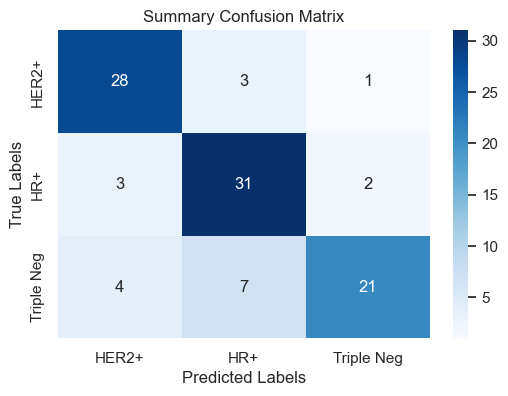

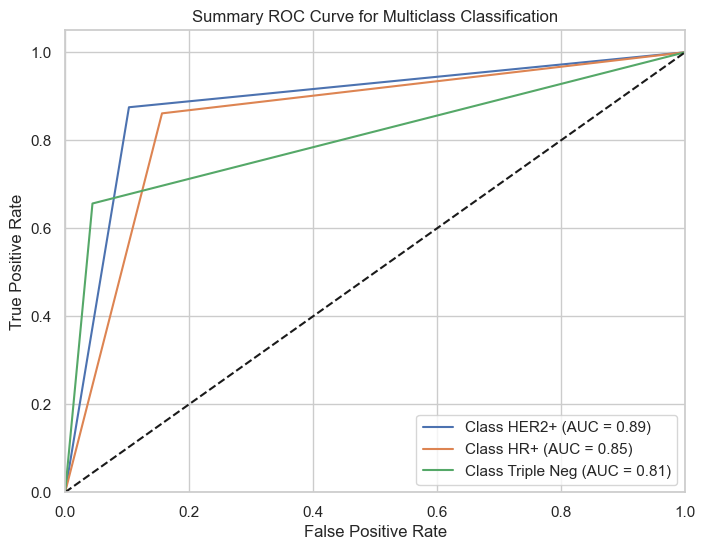

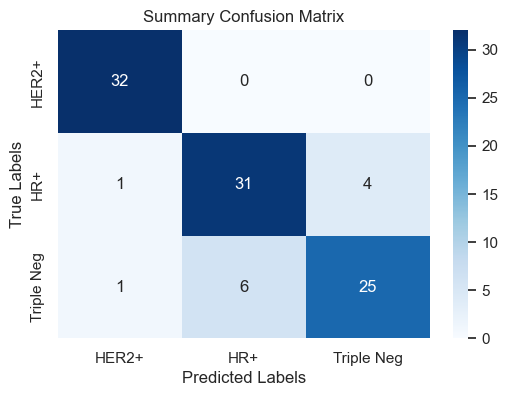

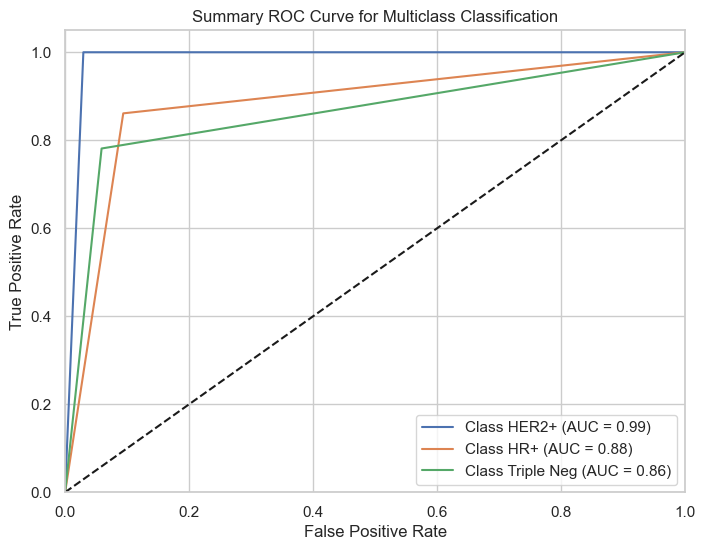

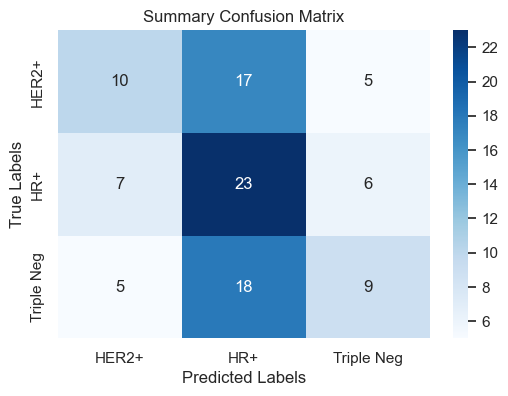

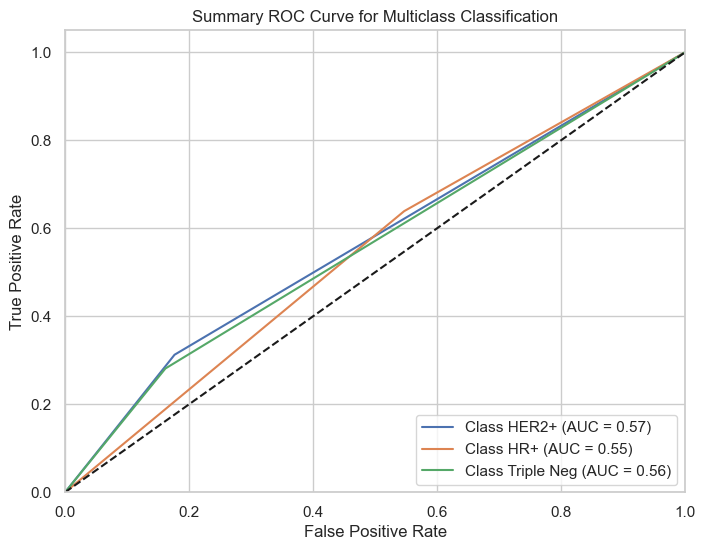

In [278]:
results1_rfc = nested_cv_rfc_all(X, y, category_labels)
results1_logreg = nested_cv_logreg_all(X, y, category_labels)
results1_knn = nested_cv_knn_all(X, y, category_labels)

## Trying different sets of features

### List 2 (features present in 2 or more feature selection methods)

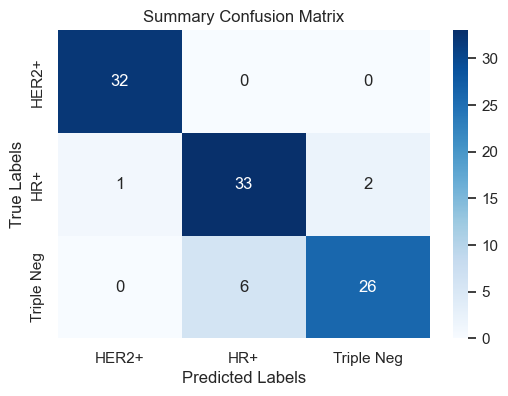

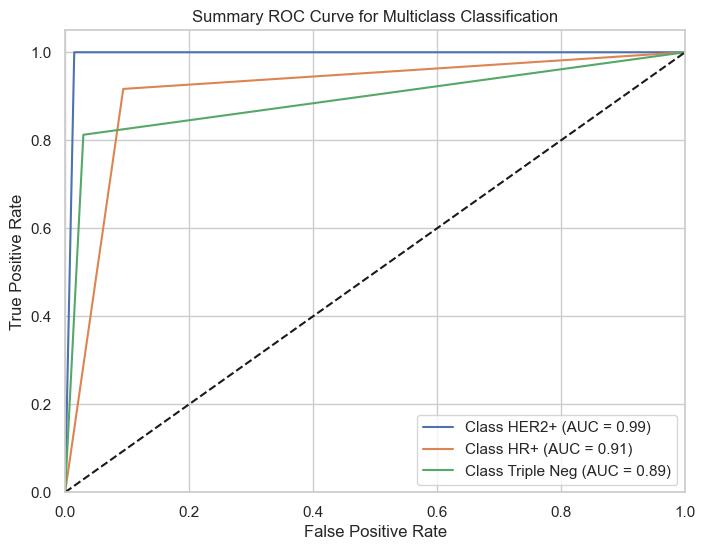

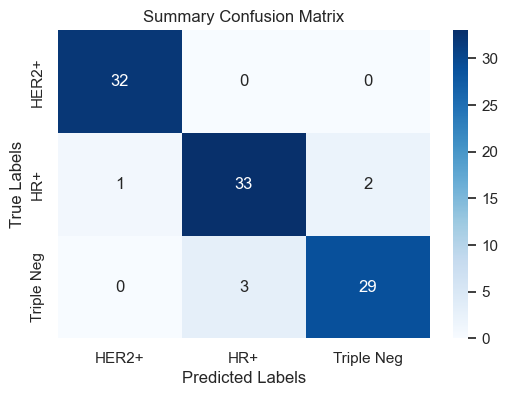

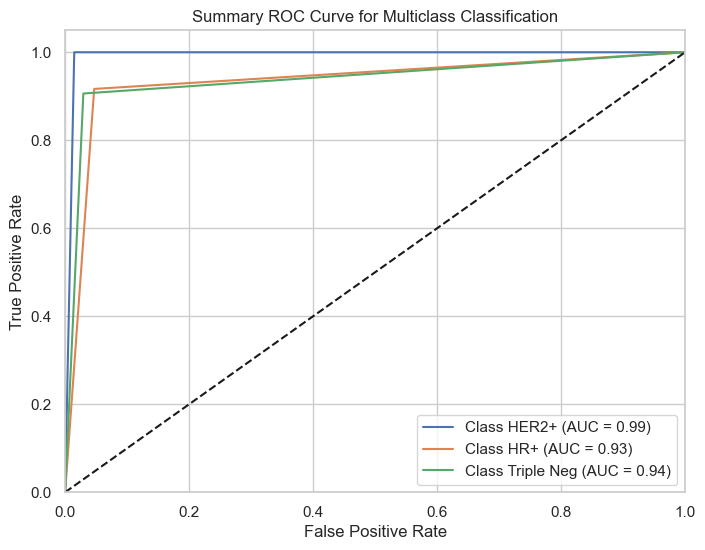

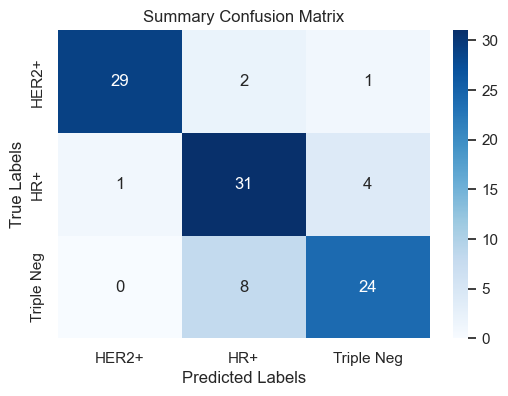

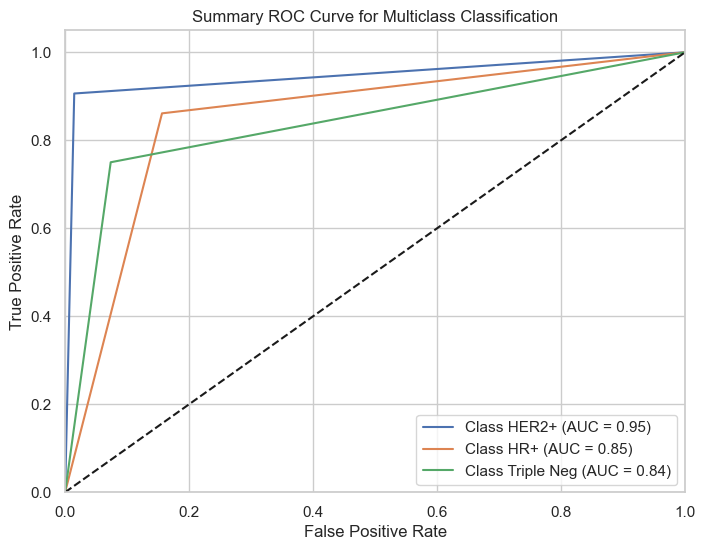

In [279]:
selected_features = [1902, 1956, 1973, 2026, 2058, 2183, 2184, 2207, 2211, 2213, 2547, 2593, 1672, 118, 192, 695, 772, 791, 854, 1061, 1091, 1559, 1643, 1656, 1678, 1900, 2017, 2021, 2024, 2210, 2218, 2750, 2776, 2791, 2817, 2825]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

results2_rfc = nested_cv_rfc_all(X, y, category_labels)
results2_logreg = nested_cv_logreg_all(X, y, category_labels)
results2_knn = nested_cv_knn_all(X, y, category_labels)

### List 3 (features present in 3 or more feature selection methods)

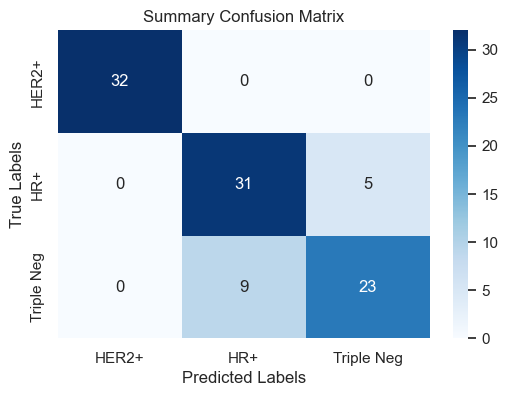

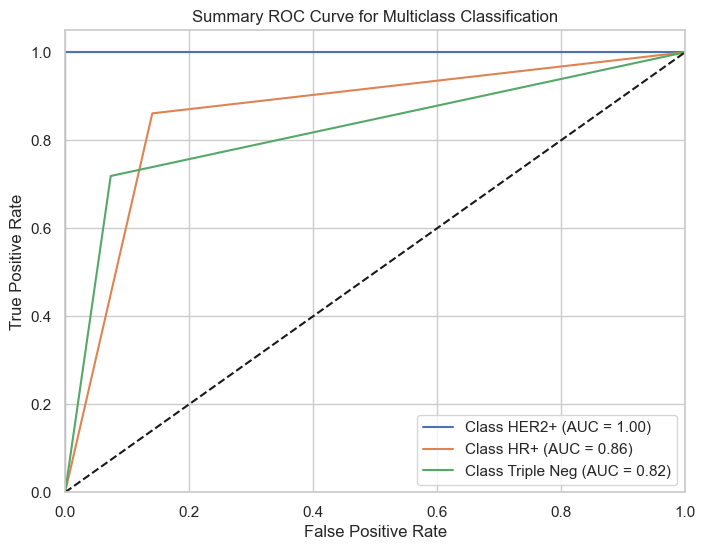

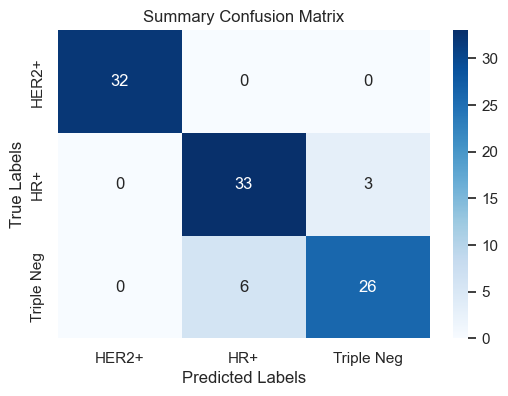

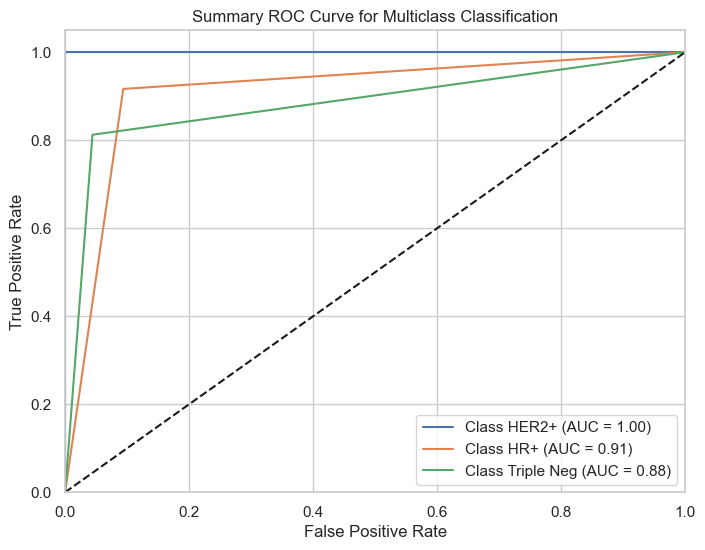

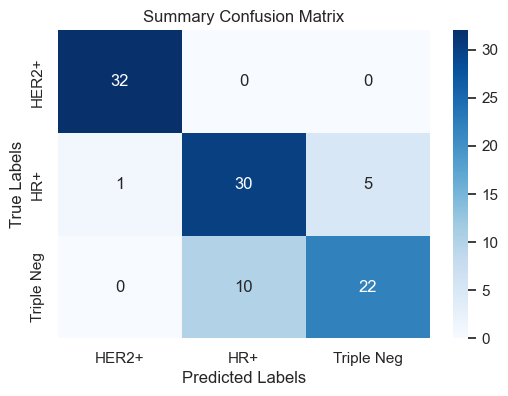

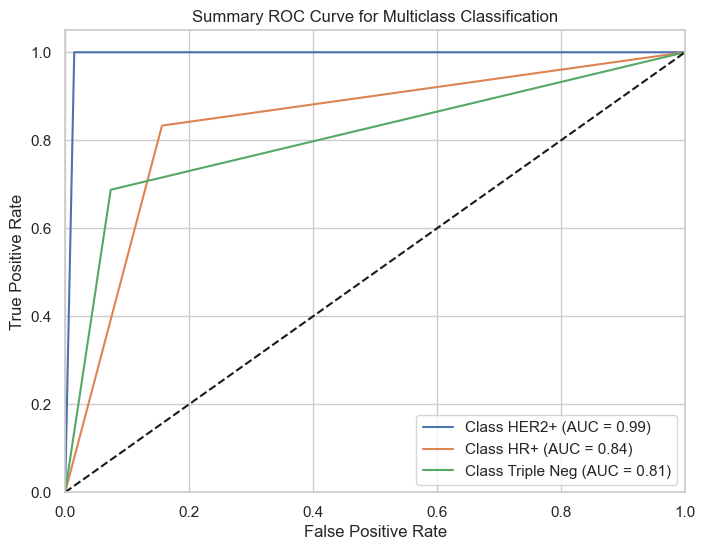

In [280]:
selected_features = [2026, 2184, 2213, 791, 1656, 1678, 1900, 2750]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

results3_rfc = nested_cv_rfc_all(X, y, category_labels)
results3_logreg = nested_cv_logreg_all(X, y, category_labels)
results3_knn = nested_cv_knn_all(X, y, category_labels)

### List 4 (features present in 4 or more feature selection methods)

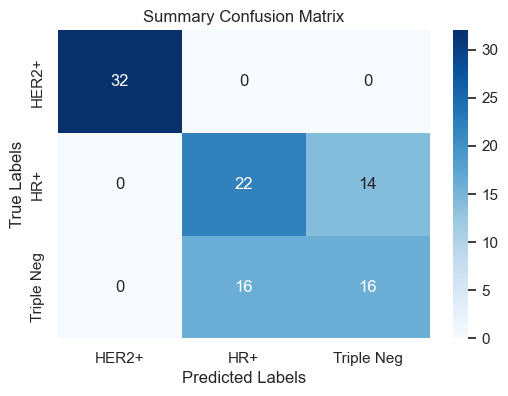

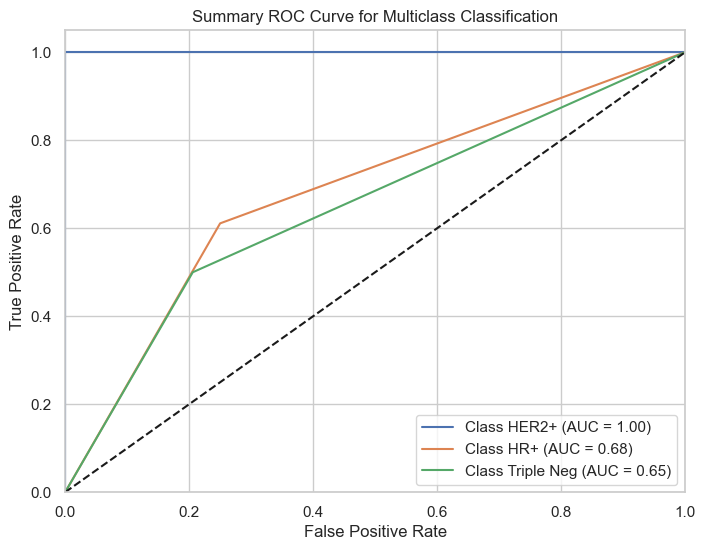

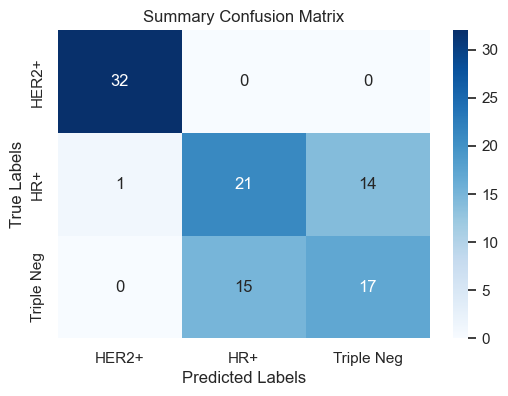

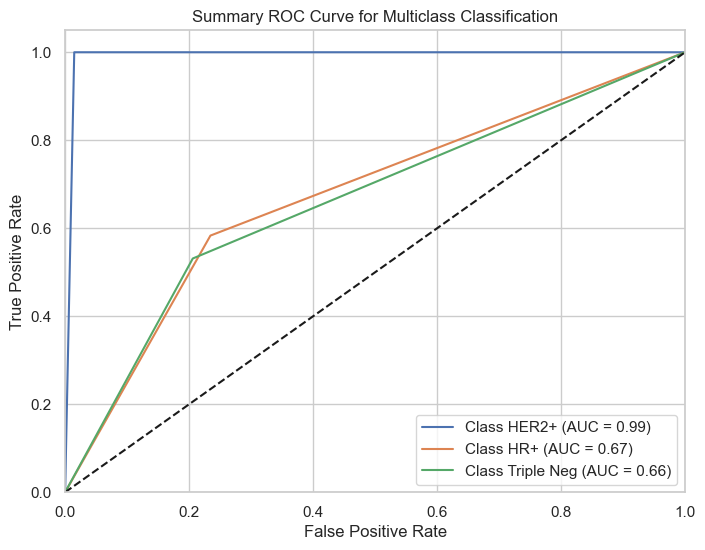

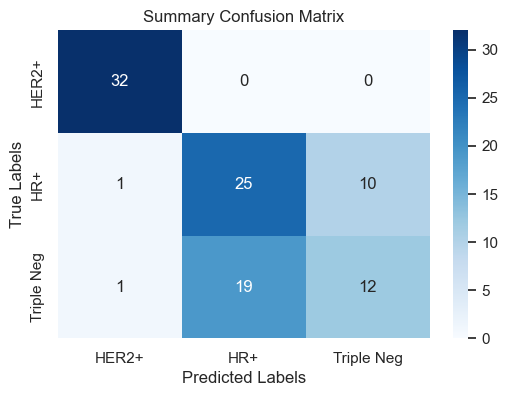

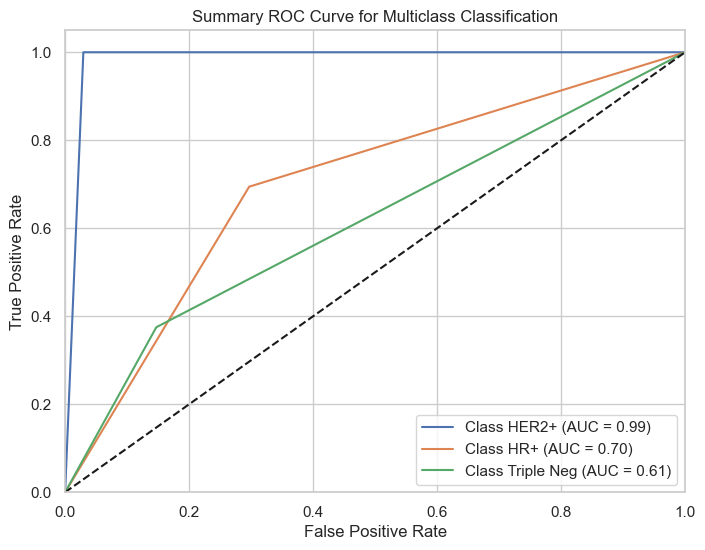

In [281]:
selected_features = [2026, 2184, 2213]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

results4_rfc = nested_cv_rfc_all(X, y, category_labels)
results4_logreg = nested_cv_logreg_all(X, y, category_labels)
results4_knn = nested_cv_knn_all(X, y, category_labels)

### List 5 (features present in all feature selection methods)

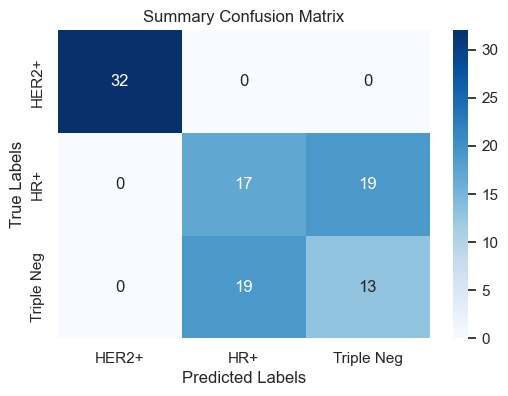

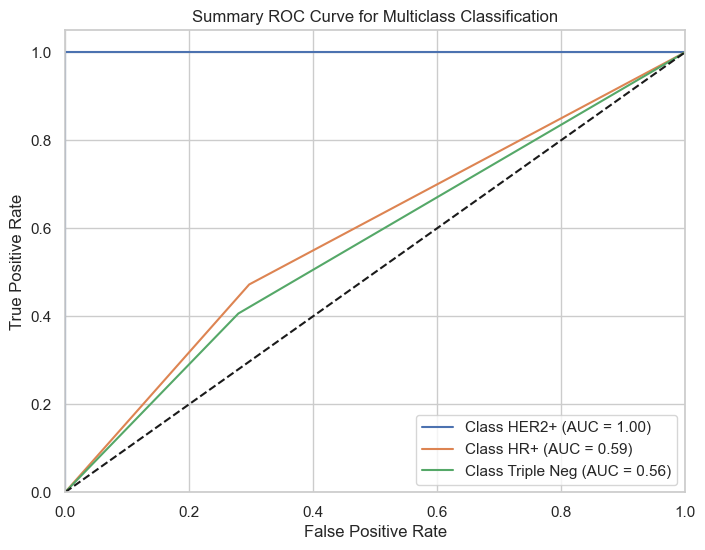

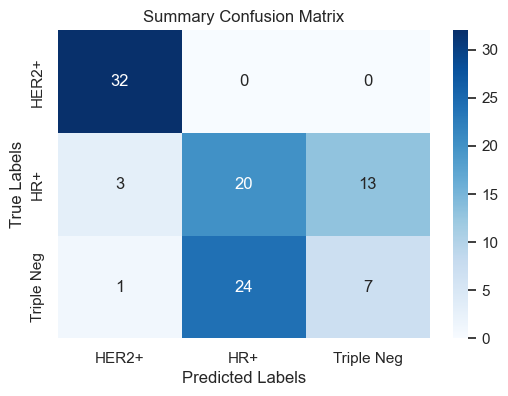

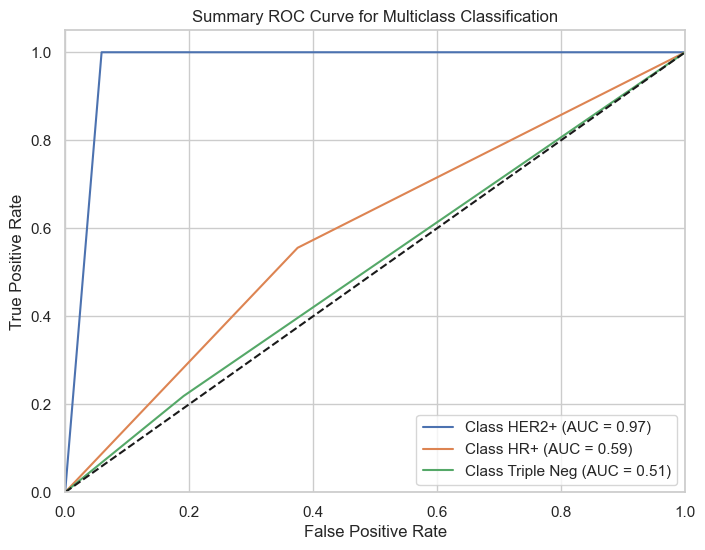

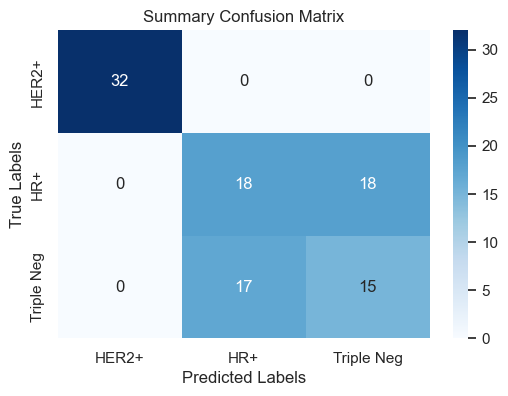

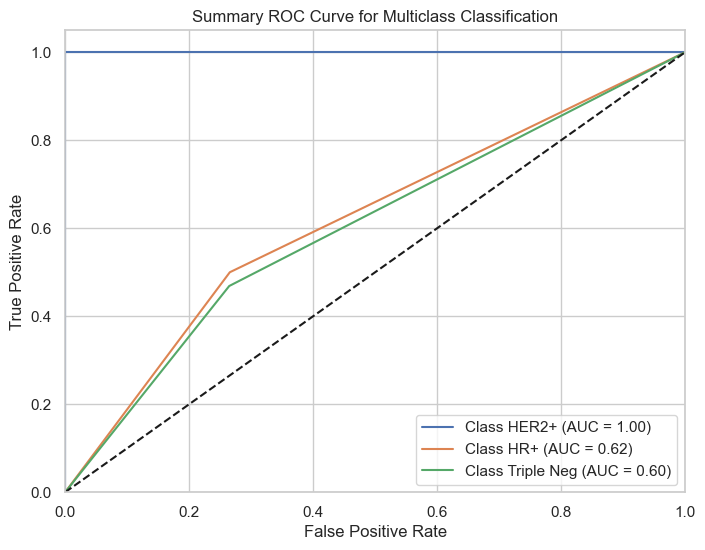

In [282]:
selected_features = [2184]
new_df_X = df_X.iloc[:, selected_features]

X = new_df_X.to_numpy()

results5_rfc = nested_cv_rfc_all(X, y, category_labels)
results5_logreg = nested_cv_logreg_all(X, y, category_labels)
results5_knn = nested_cv_knn_all(X, y, category_labels)

In [283]:
all_results = {
    'List 1': {
        'rfc': results1_rfc,
        'logreg': results1_logreg,
        'knn': results1_knn
    },
    'List 2': {
        'rfc': results2_rfc,
        'logreg': results2_logreg,
        'knn': results2_knn
    },
    'List 3': {
        'rfc': results3_rfc,
        'logreg': results3_logreg,
        'knn': results3_knn
    },
    'List 4': {
        'rfc': results4_rfc,
        'logreg': results4_logreg,
        'knn': results4_knn
    },
    'List 5': {
        'rfc': results5_rfc,
        'logreg': results5_logreg,
        'knn': results5_knn
    }
}

# Extract data for plotting
labels = list(all_results.keys())
models = ['rfc', 'logreg', 'knn']
n_lists = len(labels)
n_models = len(models)

mean_accuracies = []
std_deviations = []

for label in labels:
    for model in models:
        mean_accuracies.append(all_results[label][model]['mean_accuracy'])
        std_deviations.append(all_results[label][model]['std_accuracy'])


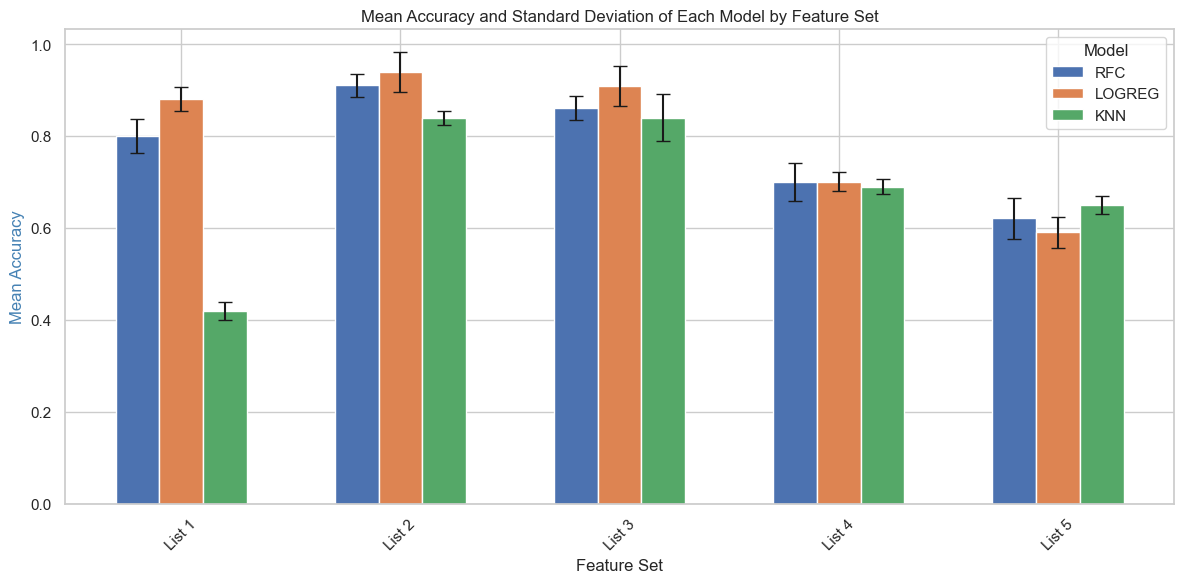

In [284]:
# Seaborn theme
sns.set_theme(style="whitegrid")

x = np.arange(n_lists)  # the label locations
width = 0.2  # the width of the bars

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bars for each model side by side
for i, model in enumerate(models):
    ax1.bar(x + i*width - width, 
            mean_accuracies[i::n_models], 
            yerr=std_deviations[i::n_models], 
            width=width, 
            label=model.upper(), 
            capsize=5)

# Customize the plot
ax1.set_xlabel('Feature Set')
ax1.set_ylabel('Mean Accuracy', color='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)
ax1.set_title('Mean Accuracy and Standard Deviation of Each Model by Feature Set')
ax1.legend(title='Model')

fig.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
plt.show()

In [288]:
print(results2_rfc["best_models"])

[RandomForestClassifier(max_depth=50, max_leaf_nodes=50, n_estimators=50,
                       random_state=42), RandomForestClassifier(max_depth=50, max_leaf_nodes=50, n_estimators=50,
                       random_state=42), RandomForestClassifier(max_depth=50, max_leaf_nodes=50, n_estimators=50,
                       random_state=42)]
